# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [353]:
# What are the features in a car that our customer are willing to pay more?

In [354]:
# Identify those features in order of importance?

In [355]:
# What features can be added and/or removed from a car that would help to drive its price up?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [356]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

In [357]:
df = pd.read_csv('data/vehicles.csv')

In [358]:
df.shape

(426880, 18)

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Checking the y column and other numeric columns

In [360]:
df['price'] = pd.to_numeric(df['price'], errors='raise')
df['year'] = pd.to_numeric(df['year'], errors='raise')
df['odometer'] = pd.to_numeric(df['odometer'], errors='raise')
df[['price','year','odometer']].corr()

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


In [361]:
# Validating range of values
df['price'].agg(['min','max','mean','count'])

min      0.000000e+00
max      3.736929e+09
mean     7.519903e+04
count    4.268800e+05
Name: price, dtype: float64

In [362]:
# Validating range of values
df['year'].agg(['min','max','mean','count'])

min        1900.000000
max        2022.000000
mean       2011.235191
count    425675.000000
Name: year, dtype: float64

In [363]:
# Validating range of values
df['odometer'].agg(['min','max','mean','count'])

min      0.000000e+00
max      1.000000e+07
mean     9.804333e+04
count    4.224800e+05
Name: odometer, dtype: float64

## Verifiying all columns and data types
#### Some columns will require data type conversion
#### There are a lot of null values that need further investion
#### Some columns do not seem to be valid for the question such as 'VIN' and 'ID'
#### A lot of the columns are object which will need to be converted to number if required

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [365]:
# A lot of NaN to be cleaned
df.head(15)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,7222379453,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,7221952215,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,7220195662,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,7209064557,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,7219485069,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [366]:
df.tail(15)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426865,7301949193,wyoming,34590,2020.0,alfa-romeo,romeo giulia sedan 4d,good,NaN,other,2498.0,clean,other,ZARFAMAN7L7629796,rwd,NaN,sedan,black,wy
426866,7301949190,wyoming,32990,2016.0,infiniti,qx80 sport utility 4d,good,8 cylinders,gas,55612.0,clean,automatic,JN8AZ2NF5G9611039,rwd,NaN,other,black,wy
426867,7301949178,wyoming,28990,2018.0,jaguar,xe 25t prestige sedan 4d,good,NaN,other,16841.0,clean,other,SAJAE4FX8JCP34579,rwd,NaN,sedan,white,wy
426868,7301843288,wyoming,0,2010.0,toyota,venza,excellent,6 cylinders,gas,155000.0,clean,automatic,4T3BK3BB0AU043625,4wd,NaN,NaN,blue,wy
426869,7301592693,wyoming,13990,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,other,75626.0,clean,other,JTNKARJE8GJ511296,fwd,NaN,hatchback,white,wy
426870,7301592119,wyoming,22990,2020.0,hyundai,sonata se sedan 4d,good,NaN,gas,3066.0,clean,other,5NPEG4JAXLH051710,fwd,NaN,sedan,blue,wy
426871,7301591639,wyoming,17990,2018.0,kia,sportage lx sport utility 4d,good,NaN,gas,34239.0,clean,other,KNDPMCAC7J7417329,NaN,NaN,SUV,NaN,wy
426872,7301591201,wyoming,32590,2020.0,mercedes-benz,c-class c 300,good,NaN,gas,19059.0,clean,other,55SWF8DB6LU325050,rwd,NaN,sedan,white,wy
426873,7301591202,wyoming,30990,2018.0,mercedes-benz,glc 300 sport,good,NaN,gas,15080.0,clean,automatic,WDC0G4JB6JV019749,rwd,NaN,other,white,wy
426874,7301591199,wyoming,33590,2018.0,lexus,gs 350 sedan 4d,good,6 cylinders,gas,30814.0,clean,automatic,JTHBZ1BLXJA012999,rwd,NaN,sedan,white,wy


### Investigating null values
#### There are a few columns with over 30% of missing values
#### The column 'size' has 71% of missing values 

In [367]:
# Calculates the missing values percentage per column
df_perc_nulls = pd.DataFrame(df.isnull().sum() / df.shape[0] * 100, columns = ['Missing Percentages'])
df_perc_nulls

,Missing Percentages
id,0.000000
region,0.000000
price,0.000000
year,0.282281
manufacturer,4.133714
model,1.236179
condition,40.785232
cylinders,41.622470
fuel,0.705819
odometer,1.030735


In [368]:
# Calculates the missing values absolute number per column
df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

## Investigating the string values

#### NO Clean up required
#### region           0.000000 -> 0% missing values
#### Candidate to OHE

In [369]:
df.region.value_counts()

columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64

In [370]:
df.region.unique()

array(['prescott', 'fayetteville', 'florida keys',
       'worcester / central MA', 'greensboro', 'hudson valley',
       'medford-ashland', 'erie', 'el paso', 'bellingham',
       'skagit / island / SJI', 'la crosse', 'auburn', 'birmingham',
       'dothan', 'florence / muscle shoals', 'gadsden-anniston',
       'huntsville / decatur', 'mobile', 'montgomery', 'tuscaloosa',
       'anchorage / mat-su', 'fairbanks', 'kenai peninsula',
       'southeast alaska', 'flagstaff / sedona', 'mohave county',
       'phoenix', 'show low', 'sierra vista', 'tucson', 'yuma',
       'fort smith', 'jonesboro', 'little rock', 'texarkana',
       'bakersfield', 'chico', 'fresno / madera', 'gold country',
       'hanford-corcoran', 'humboldt county', 'imperial county',
       'inland empire', 'los angeles', 'mendocino county', 'merced',
       'modesto', 'monterey bay', 'orange county', 'palm springs',
       'redding', 'reno / tahoe', 'sacramento', 'san diego',
       'san luis obispo', 'santa barbara',

In [371]:
# Aggregating the values and checking mean value
# Noted that agrregation was not successfully
df.groupby('region').agg(['mean','count'])['price'].sort_values(by='count', ascending=False)

/var/folders/dy/mqrlzklx5s17wl5wc4bfrw4w0000gp/T/ipykernel_56174/1544411517.py:3: FutureWarning: ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('region').agg(['mean','count'])['price'].sort_values(by='count', ascending=False)


,mean,count
region,,
columbus,1.469109e+04,3608
jacksonville,1.735700e+04,3562
spokane / coeur d'alene,6.559015e+04,2988
eugene,1.266306e+06,2985
fresno / madera,1.710026e+04,2983
...,...,...
meridian,1.575564e+04,28
southwest MS,1.012976e+05,14
kansas city,1.631136e+04,11


In [372]:
## Checking for special characteres
df.groupby('region').agg(['count','mean'])['price'].sort_values(by='count')

/var/folders/dy/mqrlzklx5s17wl5wc4bfrw4w0000gp/T/ipykernel_56174/1952942084.py:2: FutureWarning: ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('region').agg(['count','mean'])['price'].sort_values(by='count')


,count,mean
region,,
west virginia (old),8,9.423750e+03
"fort smith, AR",9,1.019722e+04
kansas city,11,1.631136e+04
southwest MS,14,1.012976e+05
meridian,28,1.575564e+04
...,...,...
fresno / madera,2983,1.710026e+04
eugene,2985,1.266306e+06
spokane / coeur d'alene,2988,6.559015e+04


#### No clean up required
#### manufacturer	4.133714 -> 4% missing values
####  Candidate to OHE

In [373]:
df.manufacturer.value_counts()

ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin          24


#### Clean up required
#### model	1.236179 -> 1% missing values
#### Lots of dirty data in the column
####  Candidate to OHE or DROP

In [374]:
df.model.value_counts()

f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: model, Length: 29649, dtype: int64

In [375]:
df.model.unique()

array([nan, 'sierra 1500 crew cab slt', 'silverado 1500', ...,
       'gand wagoneer', '96 Suburban', 'Paige Glenbrook Touring'],
      dtype=object)

In [376]:
# Aggregating the values and checking mean value
# Noted that there are special symbols in some rows
df.groupby('model').agg(['mean','count'])['price']

/var/folders/dy/mqrlzklx5s17wl5wc4bfrw4w0000gp/T/ipykernel_56174/2036802441.py:3: FutureWarning: ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('model').agg(['mean','count'])['price']


,mean,count
model,,
"""t""",27000.000000,1
#NAME?,16492.073171,41
"$362.47, $1000 down, oac, 2.9%apr $362.47,luxury low miles $1000 down, only 40k miles",24900.000000,1
%,1000.000000,1
& altima,3045.000000,1
...,...,...
♦ALL TADES WELCOME!♦,500.000000,2
♿,10999.000000,1
♿ vmi,10997.000000,2


#### Clean up required -> good = good, excellent = good, like new = good, fair = fair, new = new, salvage = poor
#### condition	40.785232 -> 40% missing values
#### Consider fillna with median, mean or predict the condition
####  Candidate to OHE

In [377]:
df.condition.value_counts()

good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

In [378]:
# Aggregating the values and checking mean value
# Noted that agrregation was not successfully
df.groupby('condition').agg(['mean','count'])['price']

/var/folders/dy/mqrlzklx5s17wl5wc4bfrw4w0000gp/T/ipykernel_56174/4117138465.py:3: FutureWarning: ['region', 'manufacturer', 'model', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('condition').agg(['mean','count'])['price']


,mean,count
condition,,
excellent,51346.825953,101467
fair,761090.005614,6769
good,32545.203102,121456
like new,36402.041978,21178
new,23657.266667,1305
salvage,3605.534110,601


#### Clean up required -> turn column into a number column
#### cylinders	41.622470 -> 41% missing values
#### Consider fillna with median, mean or predict the condition

In [379]:
df.cylinders.value_counts()

6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: cylinders, dtype: int64

#### NO Clean up required 
#### fuel	0.705819-> 0.7% missing values
####  Candidate to OHE

In [380]:
df.fuel.value_counts()

gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: fuel, dtype: int64

#### NO Clean up required 
#### title_status	1.930753 -> 2% missing values
#### Consider fillna with median, mean or predict the condition
####  Candidate to OHE

In [381]:
df.title_status.value_counts()

clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

#### NO Clean up required 
#### transmission	0.598763 -> 0.5% missing values
#### Consider fillna with median, mean or predict the condition
####  Candidate to OHE

In [382]:
df.transmission.value_counts()

automatic    336524
other         62682
manual        25118
Name: transmission, dtype: int64

#### DROP the Column

In [383]:
df.VIN.value_counts()

1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
1GCEK19J78Z219711      1
JA4AT3AW1AZ006543      1
4T1BF28B61U153724      1
JTHCF5C25A5041393      1
SAJGX2749VCOO8376      1
Name: VIN, Length: 118246, dtype: int64

#### NO Clean up required 
#### drive	30.586347 -> 30% missing values
#### Consider fillna with median, mean or predict the condition
#### Candidate to OHE

In [384]:
df.drive.value_counts()

4wd    131904
fwd    105517
rwd     58892
Name: drive, dtype: int64

#### NO Clean up required 
#### size	71.767476 -> 71% missing values
#### DROP Column - Similar to type column

In [385]:
df['size'].value_counts()

full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: size, dtype: int64

#### NO Clean up required 
#### type	21.752717 -> 22% missing values
#### Consider fillna with median, mean or predict the condition
#### Candidate to OHE

In [386]:
df.type.value_counts()

sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

In [387]:
df.type.dropna().unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon'], dtype=object)

#### NO Clean up required 
#### paint_color	30.501078 -> 30% missing values
#### Consider fillna with median, mean or predict the condition
#### Candidate to OHE

In [388]:
df.paint_color.value_counts()

white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: paint_color, dtype: int64

#### NO Clean up required 
#### state	0.000000 -> 0% missing values
#### Consider fillna with median, mean or predict the condition
#### Candidate to OHE

In [389]:
df.state.value_counts()

ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: state, dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [390]:
#Droppping columns not necessary and/or with too much missing values
# Leading to many errors ,'manufacturer'
# Dropppind ID, and VIN because there are not useful for prediction
# Dropping size because there are too many nan values
# Dropping model because of too many symbols and dirty data
# Dropping manufacturer because this error makes ML models fail at training/prediction
df_clean = df.drop(['id','VIN','size','model','manufacturer'], axis = 1)
df_clean.shape

(426880, 13)

In [391]:
# Dropping null values
df_clean_non = df_clean.dropna()
df_clean_non.shape

(122262, 13)

In [392]:
# Dropping rows with price lower than 0
df_clean_non = df_clean_non[df_clean_non['price'] > 0]
df_clean_non.shape

(117778, 13)

In [393]:
# Dropping rows with price higher than 90000
df_clean_non = df_clean_non[df_clean_non['price'] < 90000]
df_clean_non.shape

(117592, 13)

In [394]:
# Dropping rows with year older than 1980
df_clean_non = df_clean_non[df_clean_non['year'] >= 1980]
df_clean_non.shape

(114149, 13)

In [395]:
# Dropping rows with odometer higher than 200000
df_clean_non = df_clean_non[df_clean_non['odometer'] <= 200000]
df_clean_non.shape

(105107, 13)

In [396]:
# standardazing condition column
# good = good, excellent = good, like new = good, fair = fair, new = new, salvage = poor
df_clean_non.loc[df_clean_non['condition'] == 'excellent', 'condition'] = 'good'
df_clean_non.loc[df_clean_non['condition'] == 'like new', 'condition'] = 'good'
df_clean_non.loc[df_clean_non['condition'] == 'salvage', 'condition'] = 'poor'
df_clean_non.condition.unique().tolist()

['good', 'new', 'fair', 'poor']

In [397]:
# transforming into number column
df_clean_non.loc[df_clean_non['cylinders'] == '8 cylinders', 'cylinders'] = '8'
df_clean_non.loc[df_clean_non['cylinders'] == '6 cylinders', 'cylinders'] = '6'
df_clean_non.loc[df_clean_non['cylinders'] == '4 cylinders', 'cylinders'] = '4'
df_clean_non.loc[df_clean_non['cylinders'] == '5 cylinders', 'cylinders'] = '5'
df_clean_non.loc[df_clean_non['cylinders'] == '3 cylinders', 'cylinders'] = '3'
df_clean_non.loc[df_clean_non['cylinders'] == '10 cylinders', 'cylinders'] = '10'
df_clean_non.loc[df_clean_non['cylinders'] == '12 cylinders', 'cylinders'] = '12'
df_clean_non.loc[df_clean_non['cylinders'] == 'other', 'cylinders'] = '0'
df_clean_non['cylinders'] = pd.to_numeric(df_clean_non['cylinders'], errors='raise')
df_clean_non.cylinders.unique()

array([ 6,  8,  4,  5, 10,  3,  0, 12])

In [398]:
# Dropping rows with cylinders that are most likely wrong. Only valid ones are 4,6,8.
df_clean_non = df_clean_non[df_clean_non['cylinders'].isin([4,6,8])]
df_clean_non.shape

(102790, 13)

In [399]:
df_clean_non[['price','year','cylinders','odometer']].corr()

,price,year,cylinders,odometer
price,1.000000,0.517029,0.383215,-0.576071
year,0.517029,1.000000,-0.117840,-0.463725
cylinders,0.383215,-0.117840,1.000000,-0.035603
odometer,-0.576071,-0.463725,-0.035603,1.000000


In [400]:
df_clean_non.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102790 entries, 31 to 426878
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        102790 non-null  object 
 1   price         102790 non-null  int64  
 2   year          102790 non-null  float64
 3   condition     102790 non-null  object 
 4   cylinders     102790 non-null  int64  
 5   fuel          102790 non-null  object 
 6   odometer      102790 non-null  float64
 7   title_status  102790 non-null  object 
 8   transmission  102790 non-null  object 
 9   drive         102790 non-null  object 
 10  type          102790 non-null  object 
 11  paint_color   102790 non-null  object 
 12  state         102790 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 11.0+ MB


### Data Visualization

Text(0.5, 1.0, 'Price Histogram')

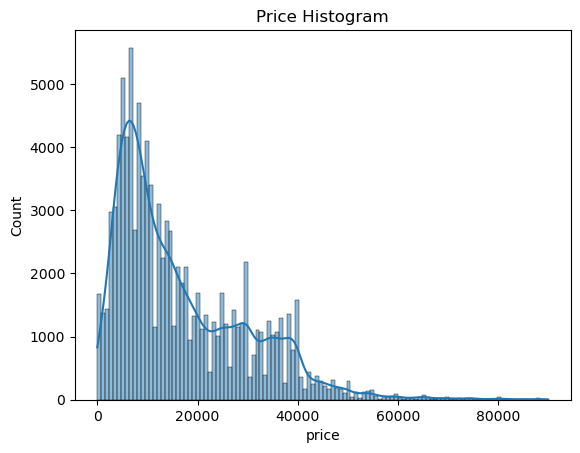

In [401]:
sns.histplot(data=df_clean_non, x="price", kde=True)
plt.title('Price Histogram')

Text(0.5, 1.0, 'Year Histogram')

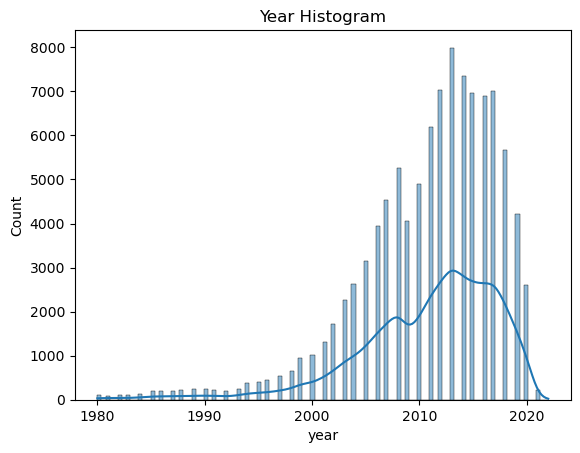

In [402]:
sns.histplot(data=df_clean_non, x="year", kde=True)
plt.title('Year Histogram')

Text(0.5, 1.0, 'Cylinders Histogram')

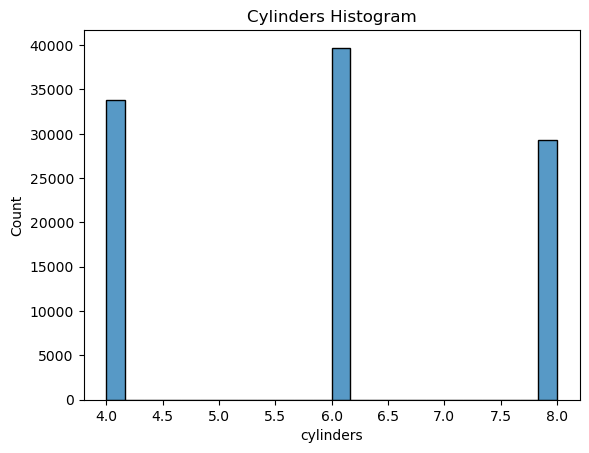

In [403]:
sns.histplot(data=df_clean_non, x="cylinders")
plt.title('Cylinders Histogram')

Text(0.5, 1.0, 'Odometer Histogram')

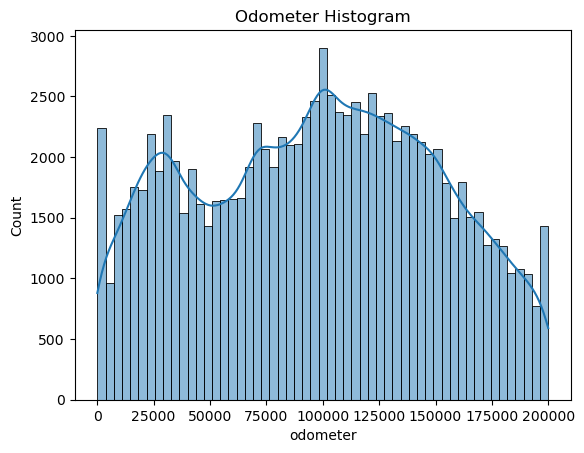

In [404]:
sns.histplot(data=df_clean_non, x="odometer", kde=True)
plt.title('Odometer Histogram')

<Axes: xlabel='odometer', ylabel='price'>

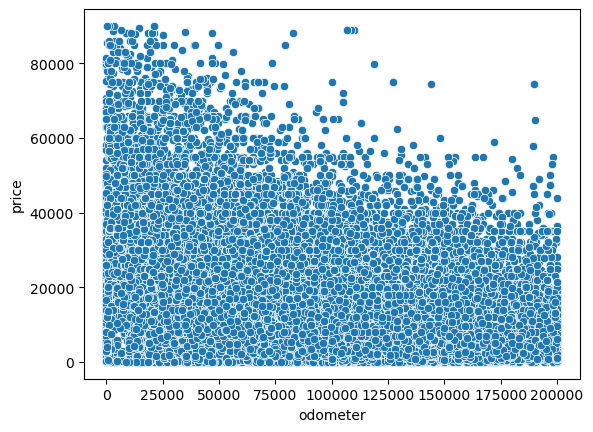

In [405]:
sns.scatterplot(data=df_clean_non, x="odometer", y="price")

<Axes: xlabel='year', ylabel='price'>

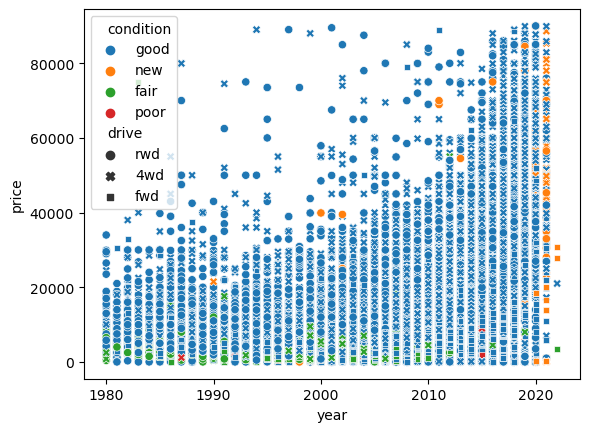

In [406]:
sns.scatterplot(data=df_clean_non, x="year", y="price", hue="condition", style="drive")

<Axes: xlabel='condition', ylabel='price'>

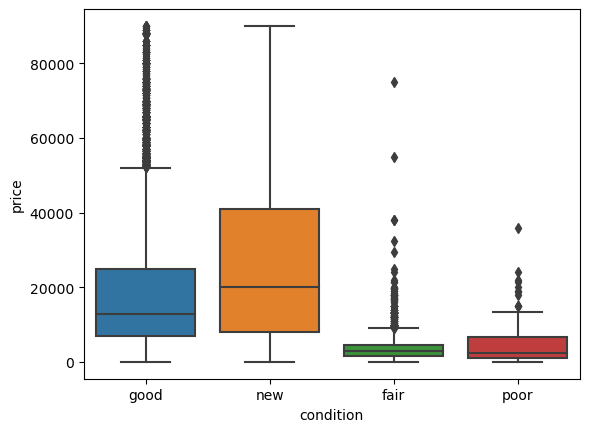

In [407]:
sns.boxplot(data=df_clean_non, x="condition", y="price")

<Axes: xlabel='title_status', ylabel='price'>

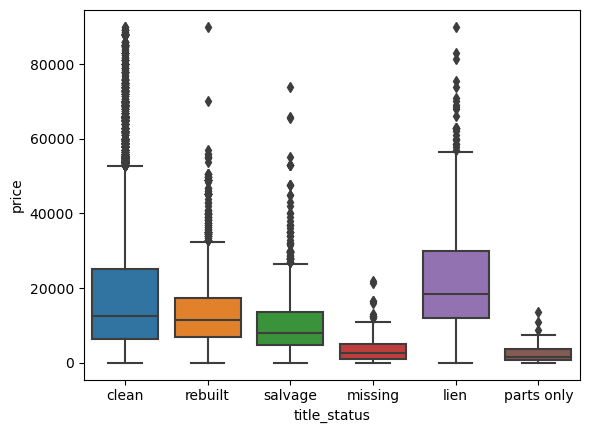

In [408]:
sns.boxplot(data=df_clean_non, x="title_status", y="price")

<Axes: xlabel='cylinders', ylabel='price'>

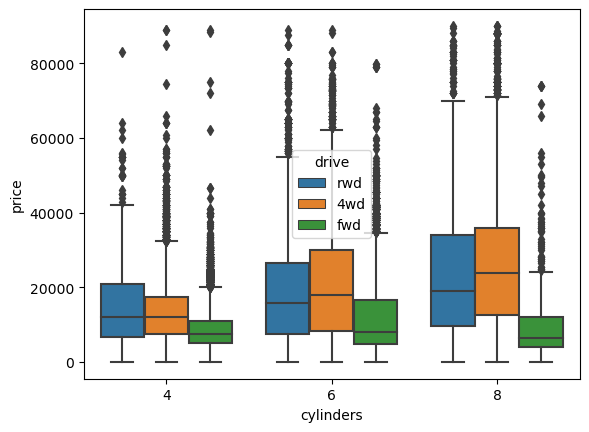

In [409]:
sns.boxplot(data=df_clean_non, x="cylinders", y="price", hue="drive")

<Axes: xlabel='transmission', ylabel='price'>

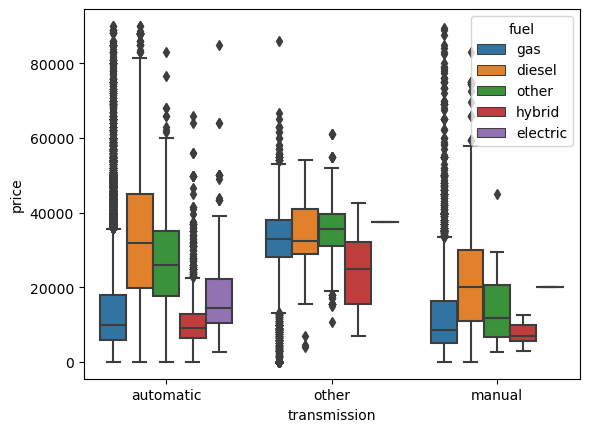

In [410]:
sns.boxplot(data=df_clean_non, x="transmission", y="price", hue="fuel")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'black'),
  Text(1, 0, 'silver'),
  Text(2, 0, 'grey'),
  Text(3, 0, 'red'),
  Text(4, 0, 'blue'),
  Text(5, 0, 'white'),
  Text(6, 0, 'brown'),
  Text(7, 0, 'yellow'),
  Text(8, 0, 'green'),
  Text(9, 0, 'custom'),
  Text(10, 0, 'orange'),
  Text(11, 0, 'purple')])

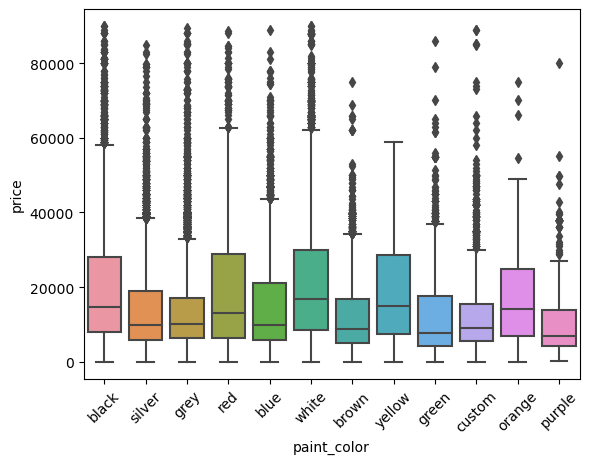

In [411]:
sns.boxplot(data=df_clean_non, x="paint_color", y="price")
plt.xticks(rotation=45)

<Axes: xlabel='type', ylabel='price'>

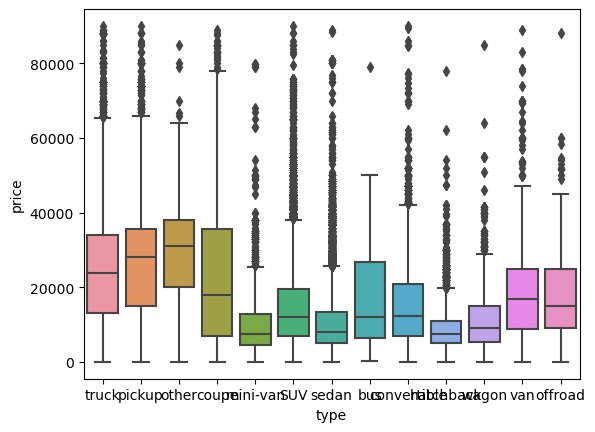

In [412]:
sns.boxplot(data=df_clean_non, x="type", y="price")

In [413]:
df_clean_non = df_clean_non.reset_index(drop=True)

df_clean_non = df_clean_non.iloc[:60000,:]
df_clean_non.shape

(60000, 13)

##### Feature engineering

In [414]:
# Getting all string columns for OHE
string_columns = [col for col in df_clean_non.columns if df_clean_non[col].dtype == 'object']
string_columns

['region',
 'condition',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'type',
 'paint_color',
 'state']

In [415]:
# Getting all numeric columns - price column
numeric_columns = [col for col in df_clean_non.columns if df_clean_non[col].dtype in ('float64','int64')]
numeric_columns.remove('price')
numeric_columns

['year', 'cylinders', 'odometer']

In [416]:
X = df_clean_non.drop(['price'], axis = 1)
y = df_clean_non['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

print(type(X_train),type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [417]:
# Adding condition and title_status 
condition_order = ['poor','fair','good','new']
title_status_order = ['parts only','missing','rebuilt','salvage','clean','lien']
categories = [condition_order, title_status_order]
categories

[['poor', 'fair', 'good', 'new'],
 ['parts only', 'missing', 'rebuilt', 'salvage', 'clean', 'lien']]

In [418]:
# Removing Ordinal Hot Encoder columns from string_columns (regular OHE)
string_columns.remove('condition')
string_columns.remove('title_status')
string_columns

['region', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']

In [419]:
col_transformer = make_column_transformer((OneHotEncoder(sparse_output = False, drop = 'if_binary', handle_unknown='ignore'), string_columns), 
                                          (OrdinalEncoder(categories = categories), ['condition','title_status']),
                                          (PolynomialFeatures(include_bias = False), numeric_columns),
                                          remainder='passthrough')
col_transformer_xdata = col_transformer.fit_transform(X)
col_transformer_feature_names = col_transformer.get_feature_names_out()
col_transformer_x_df = pd.DataFrame(col_transformer_xdata, columns=col_transformer_feature_names)
col_transformer_xydata = col_transformer.fit_transform(X,y)

In [420]:
# Investigating the results produced after fit & transform
pd.set_option('display.max_columns', 100)
col_transformer_x_df

,onehotencoder__region_SF bay area,onehotencoder__region_albany,onehotencoder__region_ames,onehotencoder__region_anchorage / mat-su,onehotencoder__region_ann arbor,onehotencoder__region_annapolis,onehotencoder__region_asheville,onehotencoder__region_athens,onehotencoder__region_atlanta,onehotencoder__region_auburn,onehotencoder__region_augusta,onehotencoder__region_bakersfield,onehotencoder__region_baltimore,onehotencoder__region_baton rouge,onehotencoder__region_battle creek,onehotencoder__region_bemidji,onehotencoder__region_billings,onehotencoder__region_birmingham,onehotencoder__region_bloomington,onehotencoder__region_bloomington-normal,onehotencoder__region_boise,onehotencoder__region_boone,onehotencoder__region_boston,onehotencoder__region_boulder,onehotencoder__region_bowling green,onehotencoder__region_bozeman,onehotencoder__region_brainerd,onehotencoder__region_brunswick,onehotencoder__region_butte,onehotencoder__region_cape cod / islands,onehotencoder__region_cedar rapids,onehotencoder__region_central NJ,onehotencoder__region_central louisiana,onehotencoder__region_central michigan,onehotencoder__region_champaign urbana,onehotencoder__region_charlotte,onehotencoder__region_chicago,onehotencoder__region_chico,onehotencoder__region_colorado springs,onehotencoder__region_columbia / jeff city,onehotencoder__region_columbus,onehotencoder__region_cumberland valley,onehotencoder__region_daytona beach,onehotencoder__region_decatur,onehotencoder__region_delaware,onehotencoder__region_denver,onehotencoder__region_des moines,onehotencoder__region_detroit metro,onehotencoder__region_dothan,onehotencoder__region_dubuque,...,onehotencoder__paint_color_green,onehotencoder__paint_color_grey,onehotencoder__paint_color_orange,onehotencoder__paint_color_purple,onehotencoder__paint_color_red,onehotencoder__paint_color_silver,onehotencoder__paint_color_white,onehotencoder__paint_color_yellow,onehotencoder__state_ak,onehotencoder__state_al,onehotencoder__state_ar,onehotencoder__state_az,onehotencoder__state_ca,onehotencoder__state_co,onehotencoder__state_ct,onehotencoder__state_dc,onehotencoder__state_de,onehotencoder__state_fl,onehotencoder__state_ga,onehotencoder__state_hi,onehotencoder__state_ia,onehotencoder__state_id,onehotencoder__state_il,onehotencoder__state_in,onehotencoder__state_ks,onehotencoder__state_ky,onehotencoder__state_la,onehotencoder__state_ma,onehotencoder__state_md,onehotencoder__state_me,onehotencoder__state_mi,onehotencoder__state_mn,onehotencoder__state_mo,onehotencoder__state_ms,onehotencoder__state_mt,onehotencoder__state_nc,onehotencoder__state_ne,onehotencoder__state_nj,onehotencoder__state_nv,ordinalencoder__condition,ordinalencoder__title_status,polynomialfeatures__year,polynomialfeatures__cylinders,polynomialfeatures__odometer,polynomialfeatures__year^2,polynomialfeatures__year cylinders,polynomialfeatures__year odometer,polynomialfeatures__cylinders^2,polynomialfeatures__cylinders odometer,polynomialfeatures__odometer^2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2013.0,6.0,128000.0,4052169.0,12078.0,257664000.0,36.0,768000.0,1.638400e+10
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2012.0,8.0,68696.0,4048144.0,16096.0,138216352.0,64.0,549568.0,4.719140e+09
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [421]:
# Visualizing the transformer
col_transformer.transformers_

[('onehotencoder',
  OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False),
  ['region', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']),
 ('ordinalencoder',
  OrdinalEncoder(categories=[['poor', 'fair', 'good', 'new'],
                             ['parts only', 'missing', 'rebuilt', 'salvage',
                              'clean', 'lien']]),
  ['condition', 'title_status']),
 ('polynomialfeatures',
  PolynomialFeatures(include_bias=False),
  ['year', 'cylinders', 'odometer'])]

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Testing Ridge() - BEST MODEL

In [422]:
param_dict_ridge = {'ohe_transform__polynomialfeatures__degree': list(range(2, 6)),
             'linereg__alpha': np.logspace(np.log10(0.5), 10, 50)}

In [423]:
pipe_ridge = Pipeline([
    ('ohe_transform', col_transformer),
    ('scaled',StandardScaler()),
    ('linereg', Ridge())
])

In [424]:
grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid = param_dict_ridge,
    scoring = 'neg_mean_squared_error',
    cv = 5
)

In [425]:
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe_transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['region',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['poor',
                                                                                                     'fair',
                                                                                                     'good',
                                                                                                     'n...
       2.66792285e+06, 4.32910748e+06, 7.02463027e+06, 1.13985228e+07,
       1.84958236e+07, 3.00122653e+07, 4.86994301e+07, 7.90221753e+07,
       1.28225406e+08, 2.08065074e+08, 3.37616984e+08, 5.47834512e+08,
       8.88944179e+08, 1.44244609e+09, 2.34058649e+09, 3.79795484e+09,
       6.16275493e+09, 1.00000000e+10]),
                         'ohe_transform__polynomialfeatures__degree': [2, 3, 4,
                                                                       5]},
             scoring='neg_mean_squared_error')

In [426]:
best_model_ridge = grid_ridge.best_estimator_
mse_grid_ridge = mean_squared_error(best_model_ridge.predict(X_test), y_test)
print(mse_grid_ridge)

45504401.26775632


In [427]:
grid_ridge.best_params_

{'linereg__alpha': 0.5, 'ohe_transform__polynomialfeatures__degree': 5}

In [428]:
best_model = grid_ridge.best_estimator_
coefficients = best_model.named_steps['linereg'].coef_
col_names = best_model.named_steps['ohe_transform'].get_feature_names_out()
coefficients_df = pd.DataFrame(coefficients, columns = ["Coefficients"], index=col_names)
coefficients_df = coefficients_df.sort_values(by="Coefficients")

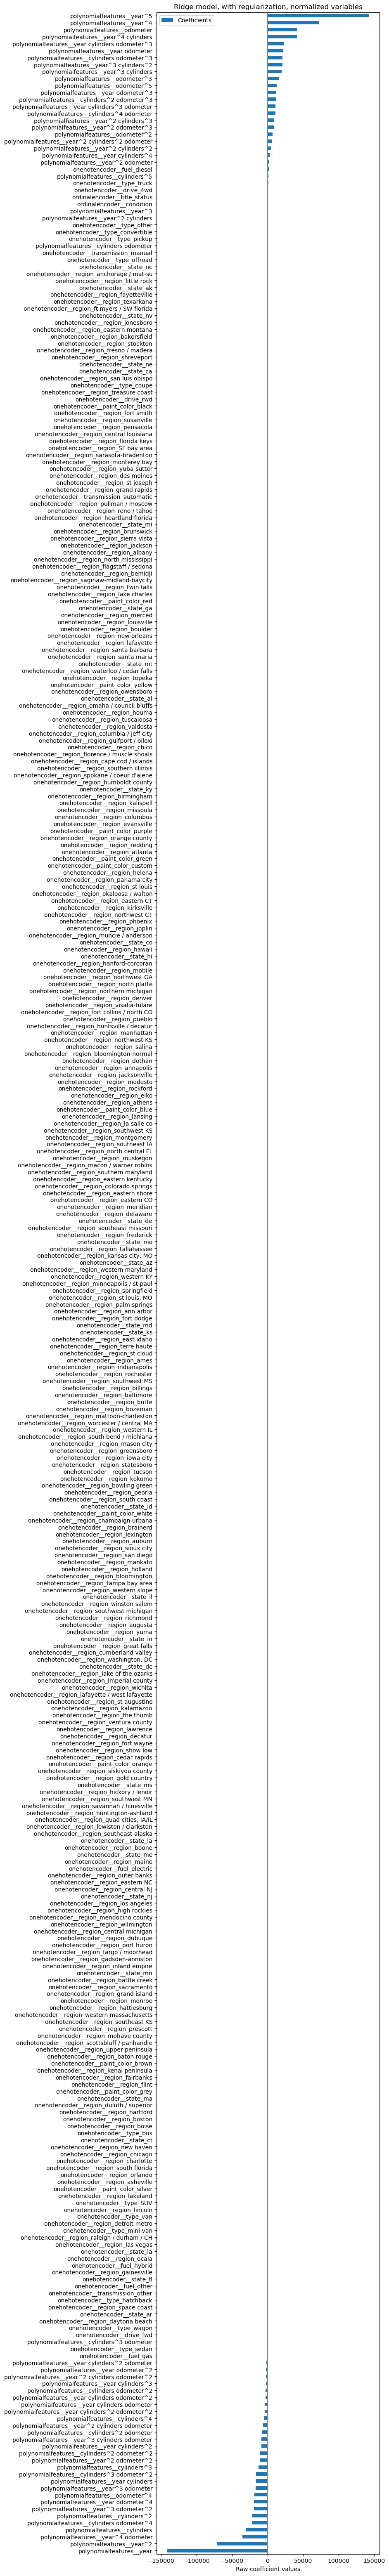

In [429]:
coefficients_df.plot.barh(figsize=(9, 80))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

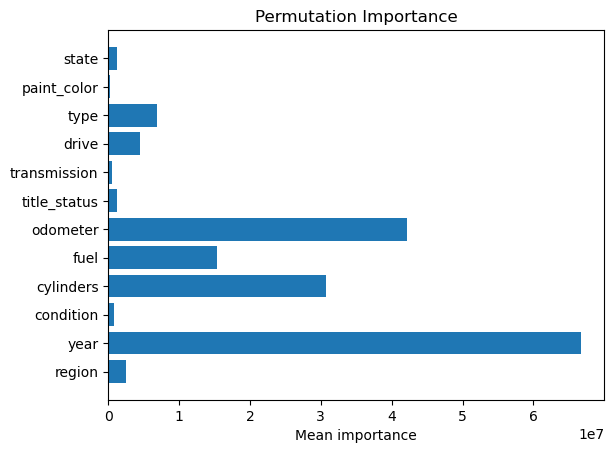

In [430]:
result = permutation_importance(grid_ridge, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

importances = result.importances_mean
feature_names = best_model.feature_names_in_

plt.barh(feature_names, importances)
plt.xlabel('Mean importance')
plt.title('Permutation Importance')
plt.show()

### Testing simple LinearRegression()

In [431]:
param_dict_linereg = {'ohe_transform__polynomialfeatures__degree': list(range(2, 8)),
                     'selector__n_features_to_select': [7]}

In [432]:
pipe_linearreg = Pipeline([
    ('ohe_transform', col_transformer),
    ('scaled',StandardScaler()),
    ('selector', SequentialFeatureSelector(estimator = LinearRegression())),
    ('linereg', LinearRegression())
])

In [433]:
grid_linereg = GridSearchCV(
    pipe_linearreg,
    param_grid = param_dict_linereg,
    scoring = 'neg_mean_squared_error',
    cv = 5
)

In [434]:
grid_linereg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe_transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['region',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['poor',
                                                                                                     'fair',
                                                                                                     'good',
                                                                                                     'n...
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['year',
                                                                          'cylinders',
                                                                          'odometer'])])),
                                       ('scaled', StandardScaler()),
                                       ('selector',
                                        SequentialFeatureSelector(estimator=LinearRegression())),
                                       ('linereg', LinearRegression())]),
             param_grid={'ohe_transform__polynomialfeatures__degree': [2, 3, 4,
                                                                       5, 6,
                                                                       7],
                         'selector__n_features_to_select': [7]},
             scoring='neg_mean_squared_error')

In [435]:
best_model_linereg = grid_linereg.best_estimator_
mse_grid_linereg = mean_squared_error(best_model_linereg.predict(X_test), y_test)
print(mse_grid_linereg)

52183977.42238642


In [436]:
grid_linereg.best_params_

{'ohe_transform__polynomialfeatures__degree': 7,
 'selector__n_features_to_select': 7}

ValueError: Shape of passed values is (7, 1), indices imply (429, 1)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Analyzing MSEs from models using never seen before test data

In [438]:
print(f"Simple ridge linear regression yields MSE of {mse_grid_ridge}")

Simple ridge linear regression yields MSE of 45504401.26775632


In [439]:
print(f"Simple linear regression with sfs yield MSE of {mse_grid_linereg}")

Simple linear regression with sfs yield MSE of 52183977.42238642


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### ==> REPORT <==

### Findings

### 1) The single most important factor that influences a car's price by far is the car's year. The newest is the car, the more expensive it tends to be. Likewise, the older the car is the less expensive it tends to be.

### 2) Other factors that also contribute to a car price - in order or importance - are odometer, cylinders, type of fuel, drive and type.

### 3) The lower odometer is the more expensive the car tends to be. The more cylinders the car has the more expensive it tends to be. Diesel cars are usually more expensive than hybrid cars or gas cars. 4 wheel drive cars are also more expensive followed by rear wheel cars and forward wheel cars. Lastly the type of car also influences in the car's price for instance trucks are more expensive than hatchbacks.

### 4) There are also a few things you must be aware that might decrease (at least not increase) the car's price. Avoid cars with colors silver, grey, orange, brown, blue and green.

### Final Recomendations

#### The recomendations above should help you build an inventory that customers would be willing to pay more. However, I would strong advise you as a next step to analyze also what kind of car provide you the most profit. Neither the cost paid for the car nor the profit made on selling the car were found in the data shared, therefore, even though those are the cars that customer would be willing to pay top dollar it does not necessaryly means the biggest profits for your company. 